In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from evtdemand import data, feature, suite

In [41]:
default_params = {
    'data_dir': '../data',
    'model_1': 'lightgbm.LGBMRegressor', 
    'model_2': 'lightgbm.LGBMRegressor',
    'model_1_kwargs': {
        'num_leaves': 50,
        'n_estimators': 100,
        'reg_lambda': 0.1
    },
    'model_2_kwargs': {
        'num_leaves': 50,
        'n_estimators': 100,
        'reg_lambda': 0.1
    },
    'data_kwargs': {
        'real_power_sub_dir': 'real_power',
        'weather_sub_dir': 'weather',
        'real_power_time_period': '_pre_september',
        'real_power_site': 'Staplegrove_CB905',
        'weather_sites': ['staplegrove'], # , 'mousehole'],
        'weather_grid_points': None,
        'weather_interpolate_method': 'interpolate',
        'use_target_delta': False
    },
    'y1_col': 'value_max',
    'y2_col': 'value_min',
    'split_kwargs': {
        'n_splits': 5, 
        'shuffle': False
    },
    'cols_subset': None, 
    'features_kwargs': {
        'features': ['temporal', 'dir_speed', 'lagged', 'demand', 'solar', 'roc', 'ts_pcs'], 
        'feature_lags': {
            'value': [1, 2, 3, 48, 96, 336],
            'solar_irradiance_staplegrove_1': [1, 2],
            # 'solar_irradiance_staplegrove_2': [1, 2],
            # 'solar_irradiance_staplegrove_3': [1, 2],
            # 'solar_irradiance_staplegrove_4': [1, 2],
            # 'solar_irradiance_staplegrove_5': [1, 2],
            'temperature_staplegrove_1': [1, 2],
            # 'temperature_staplegrove_2': [1, 2],
            # 'temperature_staplegrove_3': [1, 2],
            # 'temperature_staplegrove_4': [1, 2],
            # 'temperature_staplegrove_5': [1, 2]
        },
        'roc_features': {
            'value': 3
        },
        'sites': ['staplegrove'],
        'grid_points': None
    }
}

In [42]:
df_features, df_target = data.construct_baseline_features_target_dfs(default_params['data_dir'], **default_params['data_kwargs'])
df_features, df_target = feature.create_additional_features(df_features, df_target, **default_params['features_kwargs'])
df_features = feature.process_features(df_features, cols_subset=default_params['cols_subset'])

common_idxs = sorted(df_features.index.intersection(df_target.index))
df_features, df_target = df_features.loc[common_idxs], df_target.loc[common_idxs]

c:\users\ayrto\desktop\side projects\wpd-hackathon\evtdemand\feature.py:338: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df_trajectory_mat['value-'+str(lag)] = df_trajectory_mat['value'].shift(lag)


In [43]:
# list(df_features.columns)

c:\users\ayrto\desktop\side projects\wpd-hackathon\evtdemand\feature.py:338: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df_trajectory_mat['value-'+str(lag)] = df_trajectory_mat['value'].shift(lag)


Wall time: 32.8 s


{'y1_rmse': 9.656253557504527,
 'y2_rmse': 10.58677867829014,
 'combined_rmse': 14.356753007584425,
 'skill_score': 0.4659287269205879}

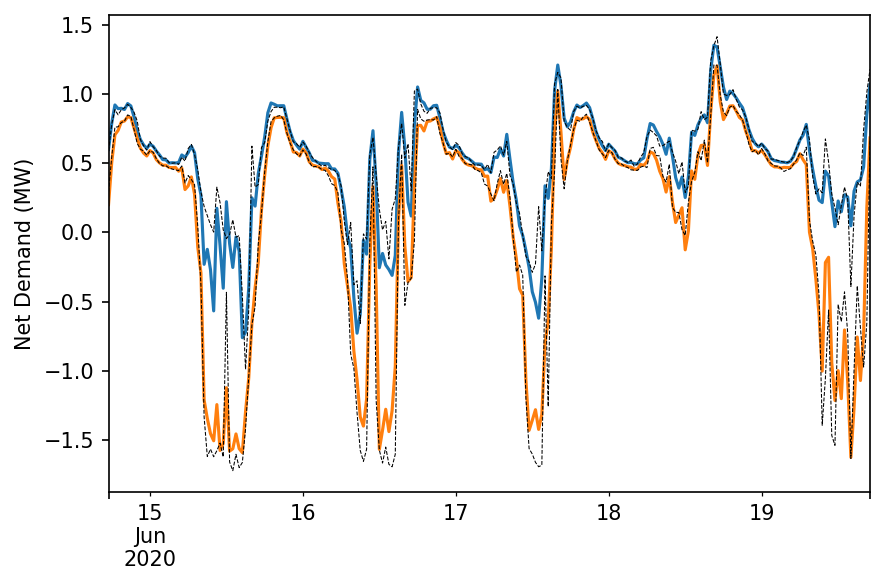

In [44]:
%%time

model_suite, error_metrics, df_pred, input_data = suite.run_parameterised_model(**default_params)
suite.plot_pred_sample(df_pred, df_target)

error_metrics

In [45]:
0.46333, 0.433122

(0.46333, 0.433122)

In [46]:
suite.calc_month_error_metrics(df_pred, df_target)

{'y1_rmse': 5.26436370656297,
 'y2_rmse': 6.237280007347413,
 'combined_rmse': 8.161935256116232,
 'skill_score': 0.43011913260005263}

In [ ]:
# We need a 1.13% reduction in RMSE, this is new prediction has a 0.69% reduction

<br>

### Submission Prediction

In [52]:
data_dir = default_params['data_dir']

df_observation_submission = data.load_real_power_dataset(f'{data_dir}/real_power', site='Staplegrove_CB905', real_power_variable='observation_variable_half_hourly', time_period='_september')
df_weather = data.load_weather_df(f'{data_dir}/weather', sites=['staplegrove'])

common_idxs = df_observation_submission.index.intersection(df_weather.index)

df_submission_features = df_observation_submission.loc[common_idxs].copy()
df_submission_features[df_weather.columns] = df_weather.loc[common_idxs].copy()

df_train_features_subset, df_train_target_subset = data.construct_baseline_features_target_dfs(data_dir, **default_params['data_kwargs'])
df_features_combined = df_train_features_subset.append(df_submission_features)
df_submission_features, *_ = feature.create_additional_features(df_features_combined, df_train_target_subset.reindex(df_features_combined.index), **default_params['features_kwargs'])
df_submission_features = feature.process_features(df_submission_features, cols_subset=default_params['cols_subset'])
df_submission_features = df_submission_features.loc[common_idxs]

X_submission = df_submission_features.values

X_submission.shape

c:\users\ayrto\desktop\side projects\wpd-hackathon\evtdemand\feature.py:338: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df_trajectory_mat['value-'+str(lag)] = df_trajectory_mat['value'].shift(lag)


(1413, 95)

In [53]:
df_pred_submission = model_suite.run_submission(
    df_target,
    df_features,
    df_submission_features,
    save_submission=True
)

df_pred_submission.head()

,value_max,value_min
time,,
2021-09-01 00:00:00,0.637261,0.584750
2021-09-01 00:30:00,0.622215,0.575644
2021-09-01 01:00:00,0.598830,0.531275
2021-09-01 01:30:00,0.556281,0.493995
2021-09-01 02:00:00,0.556692,0.496043


<br>

### Visual Inspection

<AxesSubplot:xlabel='time'>

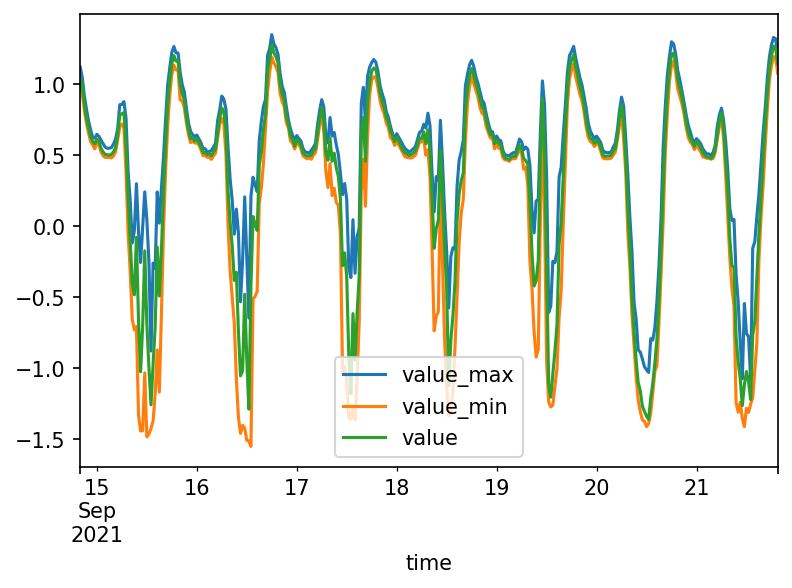

In [54]:
def load_time_df(fp, time_col='time'):
    df = pd.read_csv(fp)
    df = df.set_index(time_col)
    df.index = pd.to_datetime(df.index)
    
    return df

df_submission = load_time_df('../data/submission/predictions.csv')
df_submission = df_submission.assign(value=load_time_df('../data/real_power/MW_Staplegrove_CB905_MW_observation_variable_half_hourly_real_power_MW_september.csv')['value'])

period_length = 7*48
start_period = np.random.randint(0, df_submission.shape[0]-period_length)

# Plotting
fig, ax = plt.subplots(dpi=150)

df_submission.iloc[start_period:start_period+period_length].plot(ax=ax)

<AxesSubplot:xlabel='time'>

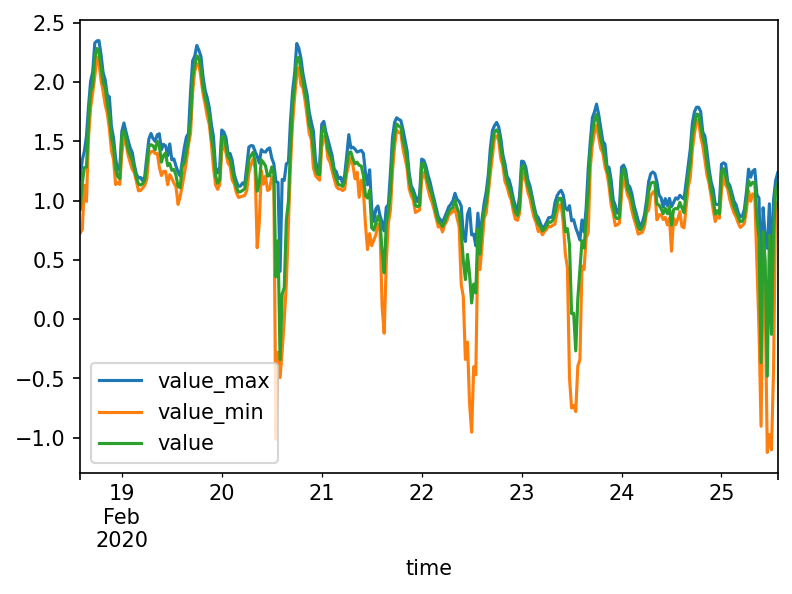

In [55]:
df_plot = df_target.assign(value=df_features['value']).dropna().copy()

period_length = 7*48
start_period = np.random.randint(0, df_plot.shape[0]-period_length)

# Plotting
fig, ax = plt.subplots(dpi=150)

df_plot.iloc[start_period:start_period+period_length].plot(ax=ax)

In [56]:
df_pred.append(df_pred_submission)[['value_max', 'value_min']].to_csv('../data/stacked_model/pred_3.csv')